# K-Means 聚类分析广告投放效果

## 项目介绍

本案例的业务场景：
假如你们公司投放广告的渠道很多，每个渠道的客户性质也可能不同，比如在优酷视频投广告和今日头条投放广告，效果可能会有差异。现在需要对广告效果分析实现有针对性的广告效果测量和优化工作。

本案例，通过各类广告渠道90天内额日均UV，平均注册率、平均搜索率、访问深度、平均停留时长、订单转化率、投放时间、素材类型、广告类型、合作方式、广告尺寸和广告卖点等特征，将渠道分类，找出每类渠道的重点特征，为加下来的业务讨论和数据分析提供支持。

参考项目：https://www.heywhale.com/mw/project/65996ae151da4f74186493bb

## 导入数据 & 数据概览

In [435]:
import pandas as pd
import numpy as np

import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [436]:
data = pd.read_csv('data/ad_performance.csv')
data.head()

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
0,A203,3.69,0.0071,0.0214,2.3071,419.77,0.0258,20,jpg,banner,roi,140*40,打折
1,A387,178.70,0.0040,0.0324,2.0489,157.94,0.0030,19,jpg,banner,cpc,140*40,满减
2,A388,91.77,0.0022,0.0530,1.8771,357.93,0.0026,4,jpg,banner,cpc,140*40,满减
3,A389,1.09,0.0074,0.3382,4.2426,364.07,0.0153,10,jpg,banner,cpc,140*40,满减
4,A390,3.37,0.0028,0.1740,2.1934,313.34,0.0007,30,jpg,banner,cpc,140*40,满减


In [437]:
data.columns

Index(['渠道代号', '日均UV', '平均注册率', '平均搜索量', '访问深度', '平均停留时间', '订单转化率', '投放总时间',
       '素材类型', '广告类型', '合作方式', '广告尺寸', '广告卖点'],
      dtype='object')

In [438]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   渠道代号    889 non-null    object 
 1   日均UV    889 non-null    float64
 2   平均注册率   889 non-null    float64
 3   平均搜索量   889 non-null    float64
 4   访问深度    889 non-null    float64
 5   平均停留时间  887 non-null    float64
 6   订单转化率   889 non-null    float64
 7   投放总时间   889 non-null    int64  
 8   素材类型    889 non-null    object 
 9   广告类型    889 non-null    object 
 10  合作方式    889 non-null    object 
 11  广告尺寸    889 non-null    object 
 12  广告卖点    889 non-null    object 
dtypes: float64(6), int64(1), object(6)
memory usage: 90.4+ KB


In [439]:
# 重复值
print("重复值情况")
print(data.duplicated().sum())
# 缺失值状况
print("缺失值情况:")
data.isnull().sum()

重复值情况
0
缺失值情况:


渠道代号      0
日均UV      0
平均注册率     0
平均搜索量     0
访问深度      0
平均停留时间    2
订单转化率     0
投放总时间     0
素材类型      0
广告类型      0
合作方式      0
广告尺寸      0
广告卖点      0
dtype: int64

**数据理解**：数据没有重复值，但是“平均停留时间”字段有2个缺失值。

### 描述性统计

In [440]:
data.describe()

,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间
count,889.000000,889.000000,889.000000,889.000000,887.000000,889.000000,889.000000
mean,540.846772,0.001408,0.030493,2.167166,262.669188,0.002852,16.052868
std,1634.410463,0.003291,0.106199,3.800528,224.364932,0.011608,8.509435
min,0.060000,0.000000,0.000000,1.000000,1.640000,0.000000,1.000000
25%,6.180000,0.000000,0.000600,1.392300,126.020000,0.000000,9.000000
50%,114.180000,0.000000,0.003200,1.793100,236.550000,0.000200,16.000000
75%,466.870000,0.001400,0.011800,2.216200,357.985000,0.002000,24.000000
max,25294.770000,0.039100,1.037000,98.979900,4450.830000,0.216500,30.000000


In [441]:
features = ['素材类型','广告类型','合作方式','广告尺寸','广告卖点']
print("分类数据的类别：")
for i in features:
    print(f"{i}: {data[i].unique()}")

分类数据的类别：
素材类型: ['jpg' 'swf' 'gif' 'sp']
广告类型: ['banner' 'tips' '不确定' '横幅' '暂停']
合作方式: ['roi' 'cpc' 'cpm' 'cpd']
广告尺寸: ['140*40' '308*388' '450*300' '600*90' '480*360' '960*126' '900*120'
 '390*270']
广告卖点: ['打折' '满减' '满赠' '秒杀' '直降' '满返']


**数据字段**：

1. **渠道代号**：渠道唯一标识
2. **日均UV**：每天的独立访问量
3. **平均注册率**：日均注册用户数/平均每日访问量
4. **平均搜索量**：每个访问的搜索量
5. **访问深度**：总页面浏览量/平均每天的访问量
6. **平均停留时间**：总停留时长/平均每天的访问量
7. **订单转化率**：总订单数量/平均每天的访客量
8. **投放总时间**：每个广告在外投放的天数
9. **素材类型**：类别型数据 - 'jpg', 'swf', 'gif', 'sp'
10. **广告类型**：类别型数据 - banner, tips, 不确定，横幅，暂停
11. **合作方式**：类别型数据 - 'roi','cpc','cpm','cpd'
12. **广告尺寸**：类别型数据
13. **广告卖点**：类别型数据 - '打折', '满减', '满赠', '秒杀', '直降', '满返'

### 相关性分析

- 除了“访问深度”与“平均停留时间”有很强的线性关系以外，其他指标没有见强线性关联

In [442]:
corr_data = data.corr(numeric_only=True).round(3)
corr_data

,日均UV,平均注册率,平均搜索量,访问深度,平均停留时间,订单转化率,投放总时间
日均UV,1.000,-0.051,-0.073,-0.022,0.035,-0.045,-0.038
平均注册率,-0.051,1.000,0.238,0.106,0.220,0.317,-0.014
平均搜索量,-0.073,0.238,1.000,0.063,0.165,0.126,-0.027
访问深度,-0.022,0.106,0.063,1.000,0.725,0.164,0.057
平均停留时间,0.035,0.220,0.165,0.725,1.000,0.253,0.047
订单转化率,-0.045,0.317,0.126,0.164,0.253,1.000,-0.005
投放总时间,-0.038,-0.014,-0.027,0.057,0.047,-0.005,1.000


<Axes: >

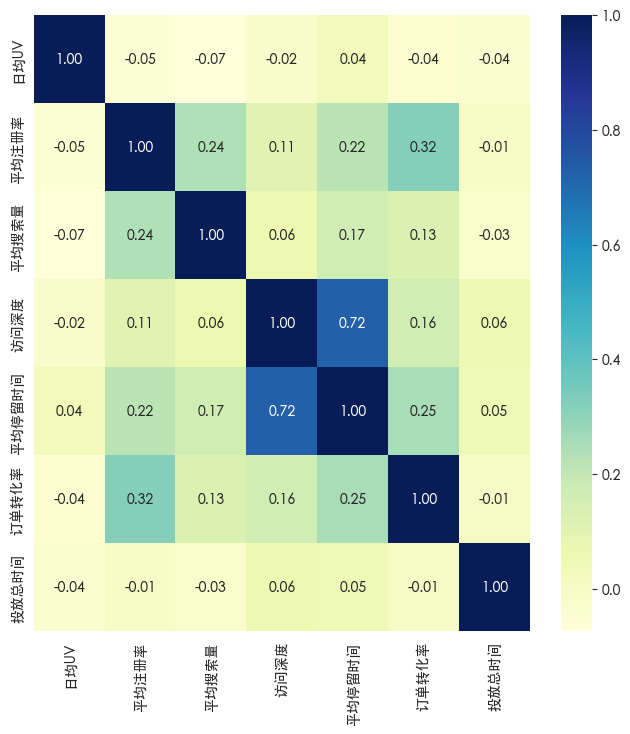

In [443]:
plt.rcParams['font.family'] = 'Heiti TC'
plt.figure(figsize=(8,8))
sns.heatmap(corr_data, annot=True, fmt=".2f", cmap="YlGnBu")

In [444]:
# # 绘制热力图
# fig = go.Figure(data=go.Heatmap(
#         z=corr_data.values,
#         x=corr_data.columns,
#         y=corr_data.columns,
#         colorscale='YlGnBu',  # 设置颜色主题
#         reversescale=True,  # 反转颜色顺序
#         zmin=-1,  # 设置颜色映射的最小值
#         zmax=1,  # 设置颜色映射的最大值
#         colorbar=dict(title='相关性'),  # 设置颜色条标题
# ))
#
# # 更新字体样式
# fig.update_layout(
#     font=dict(
#         family="STLiti, sans-serif",
#         size=14,
#         color="#000000"
#     )
# )
# # 设置图表布局
# fig.update_layout(
#     title='相关性热力图',
#     xaxis=dict(title='特征'),
#     yaxis=dict(title='特征'),
#     height=600,  # 设置图表高度
#     # width=1000,  # 设置图表宽度
#     margin=dict(l=50, r=50, b=50, t=100),  # 设置图表边距
#     template='plotly_white'  # 设置图表样式
# )
#
# # 展示图表
# fig.show()

## 数据清洗

- 去除数据内含有缺失值的列——平均停留时间

In [445]:
data.drop(columns=['平均停留时间'], axis=1, inplace=True)
data.columns

Index(['渠道代号', '日均UV', '平均注册率', '平均搜索量', '访问深度', '订单转化率', '投放总时间', '素材类型',
       '广告类型', '合作方式', '广告尺寸', '广告卖点'],
      dtype='object')

## 数据预处理

### 类别编码

在上面的描述性统计中已经得到，数据中为分类变量的特征是：素材类型、广告类型、合作方式、广告尺寸、广告卖点。

对上述的特征进行独热编码。

In [446]:
features = ['素材类型','广告类型','合作方式','广告尺寸','广告卖点']
encode_data = pd.get_dummies(data[features], dtype=int)
encode_data.head()

,素材类型_gif,素材类型_jpg,素材类型_sp,素材类型_swf,广告类型_banner,广告类型_tips,广告类型_不确定,广告类型_暂停,广告类型_横幅,合作方式_cpc,...,广告尺寸_480*360,广告尺寸_600*90,广告尺寸_900*120,广告尺寸_960*126,广告卖点_打折,广告卖点_满减,广告卖点_满赠,广告卖点_满返,广告卖点_直降,广告卖点_秒杀
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


### 数据标准化

数据标准化最常用的方法是：
1. StandardScaler
2. MinMaxScaler

本模块暂时先使用MinMaxScaler方法对数据进行标准化

In [447]:
columns = data.columns
scaled_features = columns[~columns.isin(features)][1:]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[scaled_features])

In [448]:
scaled_data.round(2)

array([[0.  , 0.18, 0.02, 0.01, 0.12, 0.66],
       [0.01, 0.1 , 0.03, 0.01, 0.01, 0.62],
       [0.  , 0.06, 0.05, 0.01, 0.01, 0.1 ],
       ...,
       [0.01, 0.01, 0.  , 0.  , 0.  , 0.72],
       [0.05, 0.  , 0.  , 0.  , 0.  , 0.31],
       [0.  , 0.  , 0.  , 0.53, 0.  , 0.62]])

In [449]:
# 合并数据
X = pd.concat([pd.DataFrame(scaled_data), encode_data], axis=1).to_numpy()

## 创建K-Means聚类模型

### 使用Elbow图判断K值

In [450]:
inertias = []
for i in range(2,9):
    kmeans = KMeans(n_clusters=i).fit(X)
    inertias.append(kmeans.inertia_/i)

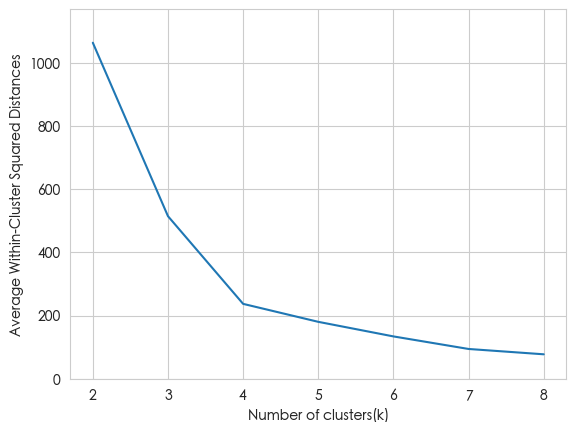

In [451]:
inertias = pd.DataFrame({'n_clusters': range(2, 9), 'inertia': inertias})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)

从肘部图可以看出，潜在的可以选择的k值有3, 4, 5。利用平均轮廓系数进一步选择最佳K-Means聚类模型。
**什么是平均轮廓系数**：

- 轮廓系数的计算公式：

  `s(i) = (b(i) - a(i)) / max(a(i), b(i))`

其中：
- a(i)：样本i到同簇其他样本的平均距离（内聚度）
- b(i)：样本i到最近其他簇的所有样本的平均距离（分离度）

取值范围：-1 到 1

- 接近1：聚类效果好
- 接近0：样本在两个簇的边界上
- 接近-1：样本可能被分错了簇

平均轮廓系数 = 所有样本轮廓系数的平均值

In [452]:
SEED = 50
score = []
ks = [3,4]
for i in ks:
    tmp_score= []
    for j in range(15):
        model = KMeans(n_clusters=i, n_init='auto', random_state=SEED)
        labels = model.fit_predict(X)
        score_tmp = silhouette_score(X, labels)
        tmp_score.append(score_tmp)
    score_mean = np.mean(tmp_score)
    score.append((i,score_mean))
max_score_index = np.argmax([i[1] for i in score])
best_k = score[max_score_index][0]
print(f"最优的K值为:{best_k}")
print(f"对应的轮廓系数是:{score[max_score_index][1]}")

最优的K值为:4
对应的轮廓系数是:0.5020981194788054


### 聚类结果特征分析

用选择的最优k值建模，对每个样本打一个聚类标签，表示它属于哪个类别。

In [453]:
final_kmeans = KMeans(n_clusters=best_k, n_init='auto', random_state=SEED)
final_labels = final_kmeans.fit_predict(X)
data['cluster'] = final_labels
data.head()

,渠道代号,日均UV,平均注册率,平均搜索量,访问深度,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点,cluster
0,A203,3.69,0.0071,0.0214,2.3071,0.0258,20,jpg,banner,roi,140*40,打折,1
1,A387,178.70,0.0040,0.0324,2.0489,0.0030,19,jpg,banner,cpc,140*40,满减,1
2,A388,91.77,0.0022,0.0530,1.8771,0.0026,4,jpg,banner,cpc,140*40,满减,1
3,A389,1.09,0.0074,0.3382,4.2426,0.0153,10,jpg,banner,cpc,140*40,满减,1
4,A390,3.37,0.0028,0.1740,2.1934,0.0007,30,jpg,banner,cpc,140*40,满减,1


#### 每个类别下的样本数量和占比情况

In [454]:
clusters = data[['cluster']].value_counts().reset_index(name='count')
clusters['percentage'] = round(clusters['count']/clusters['count'].sum(),3)
clusters

,cluster,count,percentage
0,2,349,0.393
1,0,313,0.352
2,1,154,0.173
3,3,73,0.082


#### 每个类别内部最显著的特征

沿用该项目的方法，获取每个类别内部最显著的特征，要进行以下两步：
1. 对数值型数据：获取描述性统计——获取平均值
2. 对分类型数据：获取众数

将两者合并，得到每个聚类的每个特征的重要信息。

In [455]:
features = ['日均UV','平均注册率','平均搜索量','访问深度','订单转化率','投放总时间','cluster']
means = data.loc[:,features].groupby('cluster').mean().round(3).reset_index()
mode = data.iloc[:, 7:].groupby('cluster').apply(lambda x: x.mode().iloc[0]).reset_index(drop=True)

final_data = pd.merge(means, mode, on='cluster')
final_data.head()

/var/folders/vp/8_rd4_c56g3dpqb1167z6tqr0000gn/T/ipykernel_20774/2883505324.py:3: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,cluster,日均UV,平均注册率,平均搜索量,访问深度,订单转化率,投放总时间,素材类型,广告类型,合作方式,广告尺寸,广告卖点
0,0,572.521,0.001,0.051,2.145,0.004,17.125,swf,不确定,roi,600*90,打折
1,1,613.836,0.003,0.020,2.190,0.003,15.682,jpg,banner,cpc,308*388,满减
2,2,300.205,0.001,0.016,2.270,0.002,15.350,jpg,横幅,cpc,600*90,直降
3,3,1401.525,0.001,0.033,1.727,0.002,15.603,swf,tips,cpm,450*300,打折


### 绘制雷达图

In [456]:
num_sets_max_min = scaler.fit_transform(means.iloc[:,1:])
num_sets_max_min

array([[0.24726328, 0.        , 1.        , 0.76979742, 1.        ,
        1.        ],
       [0.28477736, 1.        , 0.11428571, 0.85267035, 0.5       ,
        0.18704225],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.48571429, 0.        , 0.        ,
        0.14253521]])

In [457]:
# 创建Figure对象
fig = go.Figure()
labels = ['日均UV','平均注册率','平均搜索量','访问深度','订单转化率','投放总时间']

# 添加雷达图数据
for i in range(len(num_sets_max_min)):
    data_tmp = num_sets_max_min[i, :]
    x_data = np.concatenate((data_tmp, [data_tmp[0]]))

    fig.add_trace(go.Scatterpolar(
        r=x_data,
        theta=labels,
        fill='toself',
        name="第%d类渠道"%(i)
    ))

# 设置图表布局和样式
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[-0.2, 1.2]
        )
    ),
    showlegend=True,
    title='各聚类类别显著特征对比'
)

# 显示图表
fig.show()


### PCA降维聚类

In [458]:
from sklearn.decomposition import PCA

# 使用PCA降维到2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 创建可视化DataFrame
viz_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': data['cluster'],
    'Channel': data['渠道代号']
})

# 绘制散点图
fig = px.scatter(viz_df, x='PC1', y='PC2', color='Cluster',
                 hover_data=['Channel'],
                 title='广告渠道聚类可视化 (PCA降维)',
                 color_continuous_scale=px.colors.sequential.Plasma,width=600, height=600)

fig.show()

# 添加解释方差比
print(f"PC1解释方差: {pca.explained_variance_ratio_[0]:.3f}")
print(f"PC2解释方差: {pca.explained_variance_ratio_[1]:.3f}")

PC1解释方差: 0.389
PC2解释方差: 0.208


<Axes: xlabel='PC1', ylabel='PC2'>

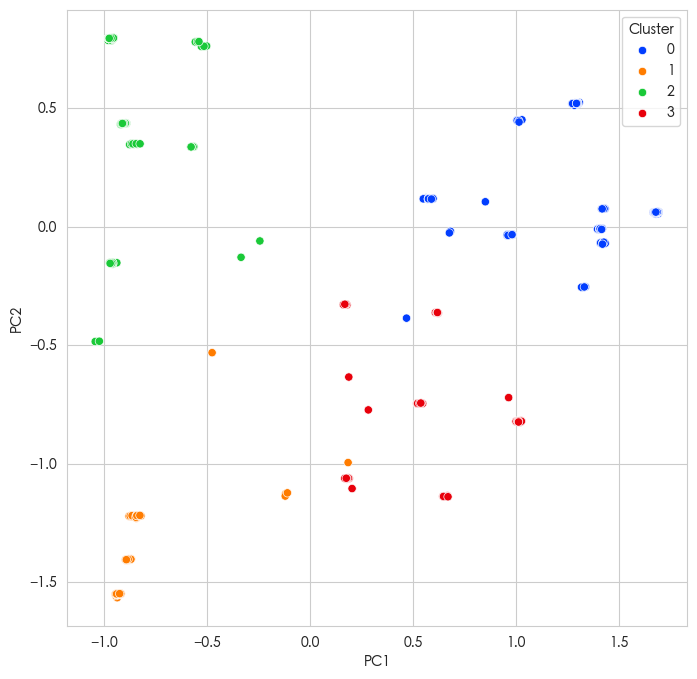

In [459]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=viz_df, x='PC1', y='PC2', hue='Cluster',palette='bright')

## 结论

聚类结果将渠道分为了4类，样本量从大到小分别为:349（类别2），313（类别0），154（类别1），73（类别3），占比分别为39.3%，35.2%，17.3%，8.2%。

分别用雷达图和PCA降维+散点图对其进行可视化。

### 分析结论
从聚类结果来看，四个类别的渠道在广告效果指标上表现出显著差异：

- **Cluster 2**
  这类广告渠道的访问深度较高（2.27），但其他指标如日均UV（300.205）、平均注册率（0.001）、平均搜索量（0.016）和订单转化率（0.002）均较低，投放总时间也较短（15.35）。此外，广告素材类型为jpg，广告类型为横幅，合作方式为cpc，广告尺寸为600*90，广告卖点为直降。这表明该类渠道用户互动深度尚可，但引流能力和转化效果较差，可能由于广告内容吸引力不足或定位不精准。整体效果质量较差，业务部门需要谨慎评估其投放价值。

- **Cluster 1**
  这类广告渠道在平均注册率（0.003）和日均UV（613.836）上表现较好，访问深度（2.19）和订单转化率（0.003）处于中等水平，但平均搜索量（0.02）较低。投放总时间为15.682，素材类型为jpg，广告类型为banner，合作方式为cpc，广告尺寸为308*388，广告卖点为满减。该类渠道在“拉新”（注册率）和引流（UV）方面有优势，但用户主动搜索意愿低，可能适合用于用户注册和初始转化，尤其适合通过满减促销提升订单量。

- **Cluster 0**
  这类广告渠道在平均搜索量（0.051）和订单转化率（0.004）上表现突出，日均UV（572.521）和访问深度（2.145）中等，但平均注册率较低（0.001）。投放总时间较长（17.125），素材类型为swf，广告类型不确定，合作方式为roi，广告尺寸为600*90，广告卖点为打折。这表明该类渠道用户搜索意图强且转化率高，适合用于促进订单转化和销售，但注册效果不佳，可能无法有效拉新。广告卖点“打折”直接吸引了价格敏感用户，符合“转化优化”的诉求。

- **CLuster 3**
  这类广告渠道的日均UV非常高（1401.525），但其他指标如平均注册率（0.001）、平均搜索量（0.033）、访问深度（1.727）和订单转化率（0.002）均较低。投放总时间为15.603，素材类型为swf，广告类型为tips，合作方式为cpm，广告尺寸为450*300，广告卖点为打折。该类渠道在引流方面优势明显，能带来大量曝光，但用户互动和转化效果差，可能适合品牌曝光或广而告之的场景，但需优化内容以提高转化。

### 业务决策建议
基于以上分析，针对每个类别提出以下业务决策：

- **Cluster 2**：由于效果质量较差，建议业务部门重新评估该类渠道的投放策略。可以考虑优化广告卖点（从“直降”改为更吸引人的促销方式）或调整合作方式（如从cpc改为cpm以降低成本）。如果保留投放，应聚焦于提升用户互动深度，例如通过A/B测试改进素材类型（从jpg到动态格式）。

- **Cluster 1**：该类渠道适合作为“拉新”和初始转化的核心渠道。业务部门应加大投放力度，利用高注册率优势，结合满减卖点推动用户注册和首单转化。同时，通过优化搜索关键词或广告内容提升平均搜索量，以弥补短板。

- **Cluster 0**：该类渠道是订单转化的高效渠道，应优先用于销售促进。建议保持roi合作方式，并强化“打折”卖点，以吸引搜索用户。但由于注册率低，不宜单独用于拉新，可与其他高注册率渠道搭配使用。

- **Cluster 3**：该类渠道适合用于品牌曝光或大规模引流，但由于转化率低，需谨慎控制投放预算。业务部门可尝试优化素材类型（如从swf到更交互式格式）和广告类型（如从tips到更精准的banner），以提高用户参与度。在促销活动中，可作为辅助渠道扩大覆盖面。

总体而言，业务部门应根据营销目标（如拉新、转化或品牌曝光）合理分配资源，并持续监控渠道表现，动态调整策略以最大化广告效果。


